In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
from collections import namedtuple

C:\Users\aw_benryane\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
data = pd.read_csv('msft us equity.csv')

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# Create normalised windows
def convert_to_window_data(array, window_size, norm=True):
    
    window_length = window_size + 1
    
    data = []
    
    for i in range(len(array) - window_length):
        data.append(array[i : i + window_length])
        
    # normalis data
    if norm==True:
        data_norm = []
        for window_data in data:
            norm_window = [(float(p) / float(window_data[0])-1) for p in window_data]
            data_norm.append(norm_window)
    else:
        data_norm = data
                                       
    return np.array(data_norm)

In [5]:
t = convert_to_window_data(data['Price'].values, 10)

In [6]:
# Split data into train and validation
def split_data(data, split_fraction=0.9):
    
    # Define split row
    split_row = int(round(data.shape[0] * split_fraction))
    
    # Split into train and val
    train = data[:split_row]
    
    # Shuffle train
    np.random.shuffle(train)
    
    val = data[split_row:]
    
    return train, val

In [7]:
def get_batches(array, batch_size):
    
    # Get num steps
    num_steps = array.shape[1] -1
    
    # Number of batches
    num_batches = array.shape[0] // batch_size
    
    # Keep only enough observations
    array = array[:num_batches * batch_size, :]
    
    # Create X and Y (all array)
    X = array[:, : num_steps]
    Y = array[:, num_steps]
    
    # Crete x and y batches
    for i in range(0, array.shape[0], batch_size):
        
        x = X[i : i + batch_size, :]
        y = Y[i : i + batch_size]
        
        # Reshape x and y
        x = x[:, :, np.newaxis]
        y = y[:, np.newaxis]
        
        yield x, y  

In [8]:
class stockRNN:
    
    def __init__(self,
                 batch_size=50,
                 num_steps=50,
                 lstm_size=128,
                 num_layers=2,
                 learning_rate=0.001,
                 grad_clip=5,
                 keep_prob=0.5,
                 sampling=False):
        
        if sampling == True:
            batch_size = 1

        # Build inputs
        tf.reset_default_graph()

        with tf.name_scope('Inputs'):
            self.inputs = tf.placeholder(tf.float32, shape=[batch_size, num_steps, 1], name='inputs')
            self.targets = tf.placeholder(tf.float32, shape=[batch_size, 1], name='targets')
            self.keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')

        # Build the RNN layers
        with tf.name_scope('RNN_Layers'):
            cell = []
            for _ in range(num_layers):
                cell.append(tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicLSTMCell(lstm_size),output_keep_prob=self.keep_prob))
    
            cell = tf.nn.rnn_cell.MultiRNNCell(cell)

        with tf.name_scope("RNN_init_state"):
            self.initial_state = cell.zero_state(batch_size, tf.float32)

        # Run the data through the RNN layers
        with tf.name_scope("RNN_forward"):
            outputs, state = tf.nn.dynamic_rnn(cell, self.inputs, initial_state=self.initial_state)

        self.final_state = state

        # First fully connected layer
        with tf.name_scope('FC-1'):
            seq_output = tf.concat(outputs, axis=1)
            x = tf.reshape(seq_output, [batch_size, -1])

            self.fc1_weights = tf.Variable(tf.truncated_normal([lstm_size*num_steps, 128], stddev=0.01), name='fc1_weights')
            fc1_biases = tf.Variable(tf.zeros(128), name='fc1_biases')

            output_fc_1 = tf.matmul(x, self.fc1_weights) + fc1_biases
            tf.summary.histogram('fc1_weights', self.fc1_weights)
            tf.summary.histogram('fc1_biases', fc1_biases)
            
            
            #output_fc_1 = tf.nn.relu(output_fc_1)

        with tf.name_scope('FC-2'):

            fc2_weights = tf.Variable(tf.truncated_normal([128, 64], stddev=0.01), name='fc2_weights')
            fc2_biases = tf.Variable(tf.zeros(64), name='fc2_biases')

            output_fc_2 = tf.matmul(output_fc_1, fc2_weights) + fc2_biases
            tf.summary.histogram('fc2_weights', fc2_weights)
            tf.summary.histogram('fc2_biases', fc2_biases)
            

        with tf.name_scope('Predictions'):
            pred_weights = tf.Variable(tf.truncated_normal([64, 1], stddev=0.01), name='pred_weights')
            pred_biases = tf.Variable(tf.zeros(1), name='pred_biases')

            self.pred = tf.matmul(output_fc_2, pred_weights) + pred_biases

            tf.summary.histogram('predictions', self.pred)
            tf.summary.histogram('pred_weights', pred_weights)
            tf.summary.histogram('pred_biases', pred_biases)

        # Loss
        with tf.name_scope('Loss'):
            self.loss = tf.reduce_mean(tf.square(self.pred - self.targets), name='loss')
            tf.summary.scalar('loss', self.loss)

        # Optimizer for training, using gradient clipping to control exploding gradients
        with tf.name_scope('train'):
            tvars = tf.trainable_variables()
            grads, _ = tf.clip_by_global_norm(tf.gradients(self.loss, tvars), grad_clip)
            train_op = tf.train.AdamOptimizer(learning_rate)
            self.optimizer = train_op.apply_gradients(zip(grads, tvars))

        self.merged = tf.summary.merge_all()

#### Train

In [9]:
# !mkdir -p checkpoints

In [10]:
# Load dataset
df = pd.read_csv('msft us equity.csv')

# Just keep values
data = df.iloc[:,1].values

In [34]:
data = data.astype('float32')

In [35]:
source = convert_to_window_data(data, 20)

In [36]:
batch_size=128
num_steps=20
lstm_size=128
num_layers=2
learning_rate=0.001
keep_prob= 0.5
epochs = 50
grad_clip=5
save_every_n = 75
train, val = split_data(source)

In [ ]:
model = stockRNN(batch_size=batch_size,
                  num_steps=num_steps,
                  learning_rate=learning_rate,
                  lstm_size=lstm_size,
                  num_layers=num_layers)

saver = tf.train.Saver(max_to_keep=100)
best_validation_loss = float('Inf')

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    train_writer = tf.summary.FileWriter('./logs/2/train', sess.graph)
    test_writer = tf.summary.FileWriter('./logs/2/test')
    
    # Use the line below to load a checkpoint and resume training
    #saver.restore(sess, 'checkpoints/anna20.ckpt')
    
    n_batches = train.shape[0] // batch_size
    iterations = n_batches * epochs
    for e in range(epochs):
        
        # Train network
        new_state = sess.run(model.initial_state)
        loss = 0
        for b, (x, y) in enumerate(get_batches(train, batch_size), 1):
            iteration = e*n_batches + b
            start = time.time()
            feed = {model.inputs: x,
                    model.targets: y,
                    model.keep_prob: keep_prob,
                    model.initial_state: new_state}
            
            summary, batch_loss, new_state, _ = sess.run([model.merged, model.loss, 
                                                          model.final_state, model.optimizer], 
                                                          feed_dict=feed)
            
            loss += batch_loss
            end = time.time()
            print('Epoch {}/{} '.format(e+1, epochs),
                  'Iteration {}/{}'.format(iteration, iterations),
                  'Training loss: {:.10f}'.format(loss/b),
                  '{:.3f} sec/batch'.format((end-start)))
            
            train_writer.add_summary(summary, iteration)
        
            if (iteration%save_every_n == 0) or (iteration == iterations):
                # Check performance, notice dropout has been set to 1
                val_loss = []
                new_state = sess.run(model.initial_state)
                for x, y in get_batches(val, batch_size):
                    feed = {model.inputs: x,
                            model.targets: y,
                            model.keep_prob: 1.0,
                            model.initial_state: new_state}
                    summary, batch_loss, new_state, pred = sess.run([model.merged, model.loss, 
                                                               model.final_state, model.pred], feed_dict=feed)
                    val_loss.append(batch_loss)
                    
                test_writer.add_summary(summary, iteration)
                
                
                mean_loss = np.mean(val_loss)
                
                
                if mean_loss < best_validation_loss:
                    print('Validation loss:', mean_loss,
                          'Saving checkpoint!')
                    saver.save(sess, "checkpoints/msft/i{}_lstm{}_loss{:.20f}.ckpt".format(iteration,
                                                                                     lstm_size,
                                                                                     mean_loss))
                    best_validation_loss = mean_loss
                    
                else:
                    print('Validation loss:', mean_loss, 'Validation loss did not improve')

Epoch 1/50  Iteration 1/1750 Training loss: 0.0091473060 0.140 sec/batch
Epoch 1/50  Iteration 2/1750 Training loss: 0.0088740578 0.094 sec/batch
Epoch 1/50  Iteration 3/1750 Training loss: 0.0087557432 0.109 sec/batch
Epoch 1/50  Iteration 4/1750 Training loss: 0.0082485575 0.112 sec/batch
Epoch 1/50  Iteration 5/1750 Training loss: 0.0082614784 0.094 sec/batch
Epoch 1/50  Iteration 6/1750 Training loss: 0.0077065861 0.109 sec/batch
Epoch 1/50  Iteration 7/1750 Training loss: 0.0076282133 0.081 sec/batch
Epoch 1/50  Iteration 8/1750 Training loss: 0.0074830932 0.125 sec/batch
Epoch 1/50  Iteration 9/1750 Training loss: 0.0073946879 0.086 sec/batch
Epoch 1/50  Iteration 10/1750 Training loss: 0.0070124259 0.134 sec/batch
Epoch 1/50  Iteration 11/1750 Training loss: 0.0067305747 0.096 sec/batch
Epoch 1/50  Iteration 12/1750 Training loss: 0.0065989033 0.140 sec/batch
Epoch 1/50  Iteration 13/1750 Training loss: 0.0064918124 0.114 sec/batch
Epoch 1/50  Iteration 14/1750 Training loss: 0.

Epoch 4/50  Iteration 112/1750 Training loss: 0.0010861420 0.112 sec/batch
Epoch 4/50  Iteration 113/1750 Training loss: 0.0010690320 0.109 sec/batch
Epoch 4/50  Iteration 114/1750 Training loss: 0.0010454352 0.159 sec/batch
Epoch 4/50  Iteration 115/1750 Training loss: 0.0010435509 0.109 sec/batch
Epoch 4/50  Iteration 116/1750 Training loss: 0.0010774552 0.096 sec/batch
Epoch 4/50  Iteration 117/1750 Training loss: 0.0010958647 0.156 sec/batch
Epoch 4/50  Iteration 118/1750 Training loss: 0.0011181562 0.127 sec/batch
Epoch 4/50  Iteration 119/1750 Training loss: 0.0011047259 0.109 sec/batch
Epoch 4/50  Iteration 120/1750 Training loss: 0.0010858084 0.094 sec/batch
Epoch 4/50  Iteration 121/1750 Training loss: 0.0010942213 0.109 sec/batch
Epoch 4/50  Iteration 122/1750 Training loss: 0.0010959881 0.125 sec/batch
Epoch 4/50  Iteration 123/1750 Training loss: 0.0011103118 0.143 sec/batch
Epoch 4/50  Iteration 124/1750 Training loss: 0.0011032622 0.096 sec/batch
Epoch 4/50  Iteration 125

Epoch 7/50  Iteration 222/1750 Training loss: 0.0007917652 0.125 sec/batch
Epoch 7/50  Iteration 223/1750 Training loss: 0.0008219433 0.140 sec/batch
Epoch 7/50  Iteration 224/1750 Training loss: 0.0008102641 0.094 sec/batch
Epoch 7/50  Iteration 225/1750 Training loss: 0.0008027794 0.125 sec/batch
Validation loss: 0.00037115556 Saving checkpoint!
Epoch 7/50  Iteration 226/1750 Training loss: 0.0007916760 0.125 sec/batch
Epoch 7/50  Iteration 227/1750 Training loss: 0.0007887102 0.094 sec/batch
Epoch 7/50  Iteration 228/1750 Training loss: 0.0007882982 0.125 sec/batch
Epoch 7/50  Iteration 229/1750 Training loss: 0.0007879716 0.094 sec/batch
Epoch 7/50  Iteration 230/1750 Training loss: 0.0007961396 0.094 sec/batch
Epoch 7/50  Iteration 231/1750 Training loss: 0.0007931177 0.094 sec/batch
Epoch 7/50  Iteration 232/1750 Training loss: 0.0007783237 0.094 sec/batch
Epoch 7/50  Iteration 233/1750 Training loss: 0.0007750207 0.094 sec/batch
Epoch 7/50  Iteration 234/1750 Training loss: 0.00

Epoch 10/50  Iteration 331/1750 Training loss: 0.0006881097 0.094 sec/batch
Epoch 10/50  Iteration 332/1750 Training loss: 0.0006985857 0.094 sec/batch
Epoch 10/50  Iteration 333/1750 Training loss: 0.0007017832 0.109 sec/batch
Epoch 10/50  Iteration 334/1750 Training loss: 0.0006917264 0.109 sec/batch
Epoch 10/50  Iteration 335/1750 Training loss: 0.0006849739 0.094 sec/batch
Epoch 10/50  Iteration 336/1750 Training loss: 0.0006900634 0.094 sec/batch
Epoch 10/50  Iteration 337/1750 Training loss: 0.0006792136 0.109 sec/batch
Epoch 10/50  Iteration 338/1750 Training loss: 0.0006832818 0.094 sec/batch
Epoch 10/50  Iteration 339/1750 Training loss: 0.0006749436 0.094 sec/batch
Epoch 10/50  Iteration 340/1750 Training loss: 0.0006749150 0.109 sec/batch
Epoch 10/50  Iteration 341/1750 Training loss: 0.0006809863 0.094 sec/batch
Epoch 10/50  Iteration 342/1750 Training loss: 0.0006785831 0.094 sec/batch
Epoch 10/50  Iteration 343/1750 Training loss: 0.0006792175 0.109 sec/batch
Epoch 10/50 

Epoch 13/50  Iteration 439/1750 Training loss: 0.0006619192 0.109 sec/batch
Epoch 13/50  Iteration 440/1750 Training loss: 0.0006543527 0.094 sec/batch
Epoch 13/50  Iteration 441/1750 Training loss: 0.0006516260 0.094 sec/batch
Epoch 13/50  Iteration 442/1750 Training loss: 0.0006476203 0.094 sec/batch
Epoch 13/50  Iteration 443/1750 Training loss: 0.0006513958 0.109 sec/batch
Epoch 13/50  Iteration 444/1750 Training loss: 0.0006452067 0.094 sec/batch
Epoch 13/50  Iteration 445/1750 Training loss: 0.0006432234 0.094 sec/batch
Epoch 13/50  Iteration 446/1750 Training loss: 0.0006424728 0.109 sec/batch
Epoch 13/50  Iteration 447/1750 Training loss: 0.0006404390 0.094 sec/batch
Epoch 13/50  Iteration 448/1750 Training loss: 0.0006412193 0.109 sec/batch
Epoch 13/50  Iteration 449/1750 Training loss: 0.0006340283 0.094 sec/batch
Epoch 13/50  Iteration 450/1750 Training loss: 0.0006308585 0.094 sec/batch
Validation loss: 0.0002782315 Saving checkpoint!
Epoch 13/50  Iteration 451/1750 Trainin

Epoch 16/50  Iteration 547/1750 Training loss: 0.0005935466 0.094 sec/batch
Epoch 16/50  Iteration 548/1750 Training loss: 0.0005878179 0.094 sec/batch
Epoch 16/50  Iteration 549/1750 Training loss: 0.0005845629 0.109 sec/batch
Epoch 16/50  Iteration 550/1750 Training loss: 0.0005873014 0.109 sec/batch
Epoch 16/50  Iteration 551/1750 Training loss: 0.0005881898 0.094 sec/batch
Epoch 16/50  Iteration 552/1750 Training loss: 0.0005861127 0.109 sec/batch
Epoch 16/50  Iteration 553/1750 Training loss: 0.0005847777 0.094 sec/batch
Epoch 16/50  Iteration 554/1750 Training loss: 0.0005802559 0.109 sec/batch
Epoch 16/50  Iteration 555/1750 Training loss: 0.0005785078 0.109 sec/batch
Epoch 16/50  Iteration 556/1750 Training loss: 0.0005800774 0.094 sec/batch
Epoch 16/50  Iteration 557/1750 Training loss: 0.0005733590 0.109 sec/batch
Epoch 16/50  Iteration 558/1750 Training loss: 0.0005732911 0.094 sec/batch
Epoch 16/50  Iteration 559/1750 Training loss: 0.0005710900 0.094 sec/batch
Epoch 16/50 

Epoch 19/50  Iteration 655/1750 Training loss: 0.0005762000 0.109 sec/batch
Epoch 19/50  Iteration 656/1750 Training loss: 0.0005821402 0.109 sec/batch
Epoch 19/50  Iteration 657/1750 Training loss: 0.0005781990 0.094 sec/batch
Epoch 19/50  Iteration 658/1750 Training loss: 0.0005803335 0.109 sec/batch
Epoch 19/50  Iteration 659/1750 Training loss: 0.0005748964 0.094 sec/batch
Epoch 19/50  Iteration 660/1750 Training loss: 0.0005714359 0.094 sec/batch
Epoch 19/50  Iteration 661/1750 Training loss: 0.0005685493 0.094 sec/batch
Epoch 19/50  Iteration 662/1750 Training loss: 0.0005614921 0.094 sec/batch
Epoch 19/50  Iteration 663/1750 Training loss: 0.0005581093 0.109 sec/batch
Epoch 19/50  Iteration 664/1750 Training loss: 0.0005522049 0.094 sec/batch
Epoch 19/50  Iteration 665/1750 Training loss: 0.0005593522 0.109 sec/batch
Epoch 20/50  Iteration 666/1750 Training loss: 0.0007108299 0.109 sec/batch
Epoch 20/50  Iteration 667/1750 Training loss: 0.0006417084 0.109 sec/batch
Epoch 20/50 

Epoch 22/50  Iteration 763/1750 Training loss: 0.0005907130 0.094 sec/batch
Epoch 22/50  Iteration 764/1750 Training loss: 0.0005863565 0.094 sec/batch
Epoch 22/50  Iteration 765/1750 Training loss: 0.0005851351 0.094 sec/batch
Epoch 22/50  Iteration 766/1750 Training loss: 0.0005830930 0.094 sec/batch
Epoch 22/50  Iteration 767/1750 Training loss: 0.0005754316 0.094 sec/batch
Epoch 22/50  Iteration 768/1750 Training loss: 0.0005789686 0.094 sec/batch
Epoch 22/50  Iteration 769/1750 Training loss: 0.0005720552 0.094 sec/batch
Epoch 22/50  Iteration 770/1750 Training loss: 0.0005757350 0.094 sec/batch
Epoch 23/50  Iteration 771/1750 Training loss: 0.0005419533 0.094 sec/batch
Epoch 23/50  Iteration 772/1750 Training loss: 0.0005515770 0.094 sec/batch
Epoch 23/50  Iteration 773/1750 Training loss: 0.0005971330 0.094 sec/batch
Epoch 23/50  Iteration 774/1750 Training loss: 0.0005978358 0.109 sec/batch
Epoch 23/50  Iteration 775/1750 Training loss: 0.0005992734 0.094 sec/batch
Epoch 23/50 

Epoch 25/50  Iteration 870/1750 Training loss: 0.0005515412 0.090 sec/batch
Epoch 25/50  Iteration 871/1750 Training loss: 0.0005504977 0.109 sec/batch
Epoch 25/50  Iteration 872/1750 Training loss: 0.0005441407 0.109 sec/batch
Epoch 25/50  Iteration 873/1750 Training loss: 0.0005452060 0.094 sec/batch
Epoch 25/50  Iteration 874/1750 Training loss: 0.0005419603 0.094 sec/batch
Epoch 25/50  Iteration 875/1750 Training loss: 0.0005463722 0.109 sec/batch
Epoch 26/50  Iteration 876/1750 Training loss: 0.0006113063 0.094 sec/batch
Epoch 26/50  Iteration 877/1750 Training loss: 0.0005787315 0.109 sec/batch
Epoch 26/50  Iteration 878/1750 Training loss: 0.0006015096 0.094 sec/batch
Epoch 26/50  Iteration 879/1750 Training loss: 0.0005955701 0.109 sec/batch
Epoch 26/50  Iteration 880/1750 Training loss: 0.0005949790 0.109 sec/batch
Epoch 26/50  Iteration 881/1750 Training loss: 0.0005591356 0.094 sec/batch
Epoch 26/50  Iteration 882/1750 Training loss: 0.0005525732 0.109 sec/batch
Epoch 26/50 

Epoch 28/50  Iteration 978/1750 Training loss: 0.0005374371 0.094 sec/batch
Epoch 28/50  Iteration 979/1750 Training loss: 0.0005347593 0.109 sec/batch
Epoch 28/50  Iteration 980/1750 Training loss: 0.0005382285 0.082 sec/batch
Epoch 29/50  Iteration 981/1750 Training loss: 0.0006079535 0.119 sec/batch
Epoch 29/50  Iteration 982/1750 Training loss: 0.0005661312 0.094 sec/batch
Epoch 29/50  Iteration 983/1750 Training loss: 0.0006031082 0.094 sec/batch
Epoch 29/50  Iteration 984/1750 Training loss: 0.0005828436 0.094 sec/batch
Epoch 29/50  Iteration 985/1750 Training loss: 0.0005873775 0.109 sec/batch
Epoch 29/50  Iteration 986/1750 Training loss: 0.0005557980 0.094 sec/batch
Epoch 29/50  Iteration 987/1750 Training loss: 0.0005506313 0.109 sec/batch
Epoch 29/50  Iteration 988/1750 Training loss: 0.0005453362 0.094 sec/batch
Epoch 29/50  Iteration 989/1750 Training loss: 0.0005586691 0.109 sec/batch
Epoch 29/50  Iteration 990/1750 Training loss: 0.0005703952 0.094 sec/batch
Epoch 29/50 

Epoch 31/50  Iteration 1085/1750 Training loss: 0.0005491971 0.094 sec/batch
Epoch 32/50  Iteration 1086/1750 Training loss: 0.0006026620 0.109 sec/batch
Epoch 32/50  Iteration 1087/1750 Training loss: 0.0006026460 0.094 sec/batch
Epoch 32/50  Iteration 1088/1750 Training loss: 0.0006193395 0.094 sec/batch
Epoch 32/50  Iteration 1089/1750 Training loss: 0.0005872569 0.094 sec/batch
Epoch 32/50  Iteration 1090/1750 Training loss: 0.0005977735 0.094 sec/batch
Epoch 32/50  Iteration 1091/1750 Training loss: 0.0005597426 0.094 sec/batch
Epoch 32/50  Iteration 1092/1750 Training loss: 0.0005626835 0.094 sec/batch
Epoch 32/50  Iteration 1093/1750 Training loss: 0.0005573789 0.094 sec/batch
Epoch 32/50  Iteration 1094/1750 Training loss: 0.0005678035 0.094 sec/batch
Epoch 32/50  Iteration 1095/1750 Training loss: 0.0005790805 0.094 sec/batch
Epoch 32/50  Iteration 1096/1750 Training loss: 0.0005792348 0.094 sec/batch
Epoch 32/50  Iteration 1097/1750 Training loss: 0.0005703895 0.109 sec/batch

Epoch 35/50  Iteration 1191/1750 Training loss: 0.0005680181 0.094 sec/batch
Epoch 35/50  Iteration 1192/1750 Training loss: 0.0005111468 0.109 sec/batch
Epoch 35/50  Iteration 1193/1750 Training loss: 0.0005810278 0.089 sec/batch
Epoch 35/50  Iteration 1194/1750 Training loss: 0.0005586044 0.135 sec/batch
Epoch 35/50  Iteration 1195/1750 Training loss: 0.0005650856 0.100 sec/batch
Epoch 35/50  Iteration 1196/1750 Training loss: 0.0005462041 0.126 sec/batch
Epoch 35/50  Iteration 1197/1750 Training loss: 0.0005414400 0.094 sec/batch
Epoch 35/50  Iteration 1198/1750 Training loss: 0.0005337174 0.094 sec/batch
Epoch 35/50  Iteration 1199/1750 Training loss: 0.0005391238 0.094 sec/batch
Epoch 35/50  Iteration 1200/1750 Training loss: 0.0005512877 0.094 sec/batch
Validation loss: 0.00027204605 Validation loss did not improve
Epoch 35/50  Iteration 1201/1750 Training loss: 0.0005438964 0.094 sec/batch
Epoch 35/50  Iteration 1202/1750 Training loss: 0.0005416189 0.109 sec/batch
Epoch 35/50  

Epoch 38/50  Iteration 1297/1750 Training loss: 0.0006525405 0.096 sec/batch
Epoch 38/50  Iteration 1298/1750 Training loss: 0.0006482512 0.109 sec/batch
Epoch 38/50  Iteration 1299/1750 Training loss: 0.0006170331 0.081 sec/batch
Epoch 38/50  Iteration 1300/1750 Training loss: 0.0006037896 0.125 sec/batch
Epoch 38/50  Iteration 1301/1750 Training loss: 0.0005720367 0.081 sec/batch
Epoch 38/50  Iteration 1302/1750 Training loss: 0.0005661472 0.125 sec/batch
Epoch 38/50  Iteration 1303/1750 Training loss: 0.0005640264 0.081 sec/batch
Epoch 38/50  Iteration 1304/1750 Training loss: 0.0005697846 0.109 sec/batch
Epoch 38/50  Iteration 1305/1750 Training loss: 0.0005795445 0.096 sec/batch
Epoch 38/50  Iteration 1306/1750 Training loss: 0.0005785945 0.109 sec/batch
Epoch 38/50  Iteration 1307/1750 Training loss: 0.0005664014 0.096 sec/batch
Epoch 38/50  Iteration 1308/1750 Training loss: 0.0005749086 0.109 sec/batch
Epoch 38/50  Iteration 1309/1750 Training loss: 0.0005787770 0.094 sec/batch

Epoch 41/50  Iteration 1403/1750 Training loss: 0.0005904655 0.081 sec/batch
Epoch 41/50  Iteration 1404/1750 Training loss: 0.0005929739 0.094 sec/batch
Epoch 41/50  Iteration 1405/1750 Training loss: 0.0006128341 0.094 sec/batch
Epoch 41/50  Iteration 1406/1750 Training loss: 0.0005780072 0.109 sec/batch
Epoch 41/50  Iteration 1407/1750 Training loss: 0.0005813180 0.096 sec/batch
Epoch 41/50  Iteration 1408/1750 Training loss: 0.0005735709 0.109 sec/batch
Epoch 41/50  Iteration 1409/1750 Training loss: 0.0005740316 0.096 sec/batch
Epoch 41/50  Iteration 1410/1750 Training loss: 0.0005950556 0.109 sec/batch
Epoch 41/50  Iteration 1411/1750 Training loss: 0.0005953580 0.081 sec/batch
Epoch 41/50  Iteration 1412/1750 Training loss: 0.0005798124 0.125 sec/batch
Epoch 41/50  Iteration 1413/1750 Training loss: 0.0005800816 0.081 sec/batch
Epoch 41/50  Iteration 1414/1750 Training loss: 0.0005774354 0.125 sec/batch
Epoch 41/50  Iteration 1415/1750 Training loss: 0.0005763123 0.081 sec/batch

Epoch 44/50  Iteration 1509/1750 Training loss: 0.0005954082 0.094 sec/batch
Epoch 44/50  Iteration 1510/1750 Training loss: 0.0006094083 0.094 sec/batch
Epoch 44/50  Iteration 1511/1750 Training loss: 0.0005732981 0.094 sec/batch
Epoch 44/50  Iteration 1512/1750 Training loss: 0.0005621845 0.125 sec/batch
Epoch 44/50  Iteration 1513/1750 Training loss: 0.0005577622 0.125 sec/batch
Epoch 44/50  Iteration 1514/1750 Training loss: 0.0005628495 0.109 sec/batch
Epoch 44/50  Iteration 1515/1750 Training loss: 0.0005717369 0.109 sec/batch
Epoch 44/50  Iteration 1516/1750 Training loss: 0.0005632884 0.140 sec/batch
Epoch 44/50  Iteration 1517/1750 Training loss: 0.0005478685 0.109 sec/batch
Epoch 44/50  Iteration 1518/1750 Training loss: 0.0005495123 0.109 sec/batch
Epoch 44/50  Iteration 1519/1750 Training loss: 0.0005530076 0.109 sec/batch
Epoch 44/50  Iteration 1520/1750 Training loss: 0.0005508712 0.150 sec/batch
Epoch 44/50  Iteration 1521/1750 Training loss: 0.0005501810 0.109 sec/batch

Epoch 47/50  Iteration 1616/1750 Training loss: 0.0005412293 0.094 sec/batch
Epoch 47/50  Iteration 1617/1750 Training loss: 0.0005523794 0.094 sec/batch
Epoch 47/50  Iteration 1618/1750 Training loss: 0.0005411552 0.094 sec/batch
Epoch 47/50  Iteration 1619/1750 Training loss: 0.0005505426 0.094 sec/batch
Epoch 47/50  Iteration 1620/1750 Training loss: 0.0005513102 0.094 sec/batch
Epoch 47/50  Iteration 1621/1750 Training loss: 0.0005536604 0.094 sec/batch
Epoch 47/50  Iteration 1622/1750 Training loss: 0.0005458928 0.109 sec/batch
Epoch 47/50  Iteration 1623/1750 Training loss: 0.0005599807 0.109 sec/batch
Epoch 47/50  Iteration 1624/1750 Training loss: 0.0005668843 0.094 sec/batch
Epoch 47/50  Iteration 1625/1750 Training loss: 0.0005654301 0.094 sec/batch
Epoch 47/50  Iteration 1626/1750 Training loss: 0.0005578826 0.094 sec/batch
Epoch 47/50  Iteration 1627/1750 Training loss: 0.0005535563 0.109 sec/batch
Epoch 47/50  Iteration 1628/1750 Training loss: 0.0005478867 0.094 sec/batch

Epoch 50/50  Iteration 1723/1750 Training loss: 0.0005723494 0.094 sec/batch
Epoch 50/50  Iteration 1724/1750 Training loss: 0.0005771892 0.109 sec/batch


#### Sampling

In [14]:
last = tf.train.latest_checkpoint('checkpoints/msft/')

In [15]:
model = stockRNN(batch_size = batch_size,
                 num_steps = num_steps,
                 lstm_size=lstm_size,
                 sampling=True)

saver = tf.train.Saver()

with tf.Session() as sess:
    
    saver.restore(sess, last)
    
    prediction_seqs = []
    
    for i in range(len(val) // num_steps):
        
        # Reset initial state
        new_state = sess.run(model.initial_state)
        
        # Define and reshape the input tensor
        x = val[(len(val)-1) - i * num_steps][:num_steps]
        x = x[np.newaxis,:,np.newaxis]
        
        predicted = []
        
        for j in range(num_steps):
            
            feed = {model.inputs:x,
                    model.initial_state:new_state, 
                    model.keep_prob:1.0}
            
            pred, new_state = sess.run([model.pred,
                                        model.final_state],
                                       feed_dict=feed)
            
            # Append prediction
            predicted.append(float(pred.squeeze()))
            
            # Modify x tensor
            x=x[:,1:,:]
            
            # Add the prediction
            x = np.insert(x.flatten(), [num_steps-1], predicted[-1], axis=0).reshape((1,num_steps,1))
            p = (x+1).reshape(-1)
            x = np.array([(float(i)/p[0] -1) for i in p])
            x = x[np.newaxis,:,np.newaxis]

        
        prediction_seqs.append(predicted)

INFO:tensorflow:Restoring parameters from checkpoints/msft/i1750_lstm128_loss0.00025392000679858029.ckpt


In [16]:
prediction_seqs[0]

[0.06396044790744781,
 0.07057229429483414,
 0.0643354132771492,
 0.06721551716327667,
 0.07443515956401825,
 0.06794999539852142,
 0.05509030073881149,
 0.039471276104450226,
 0.03550288453698158,
 0.038789477199316025,
 0.03405461832880974,
 0.03357506915926933,
 0.022193286567926407,
 0.02651982009410858,
 0.03222739323973656,
 0.03856302425265312,
 0.0380011610686779,
 0.04107300937175751,
 0.041780274361371994,
 0.03999784216284752]

In [17]:
y_val = val[:,num_steps]

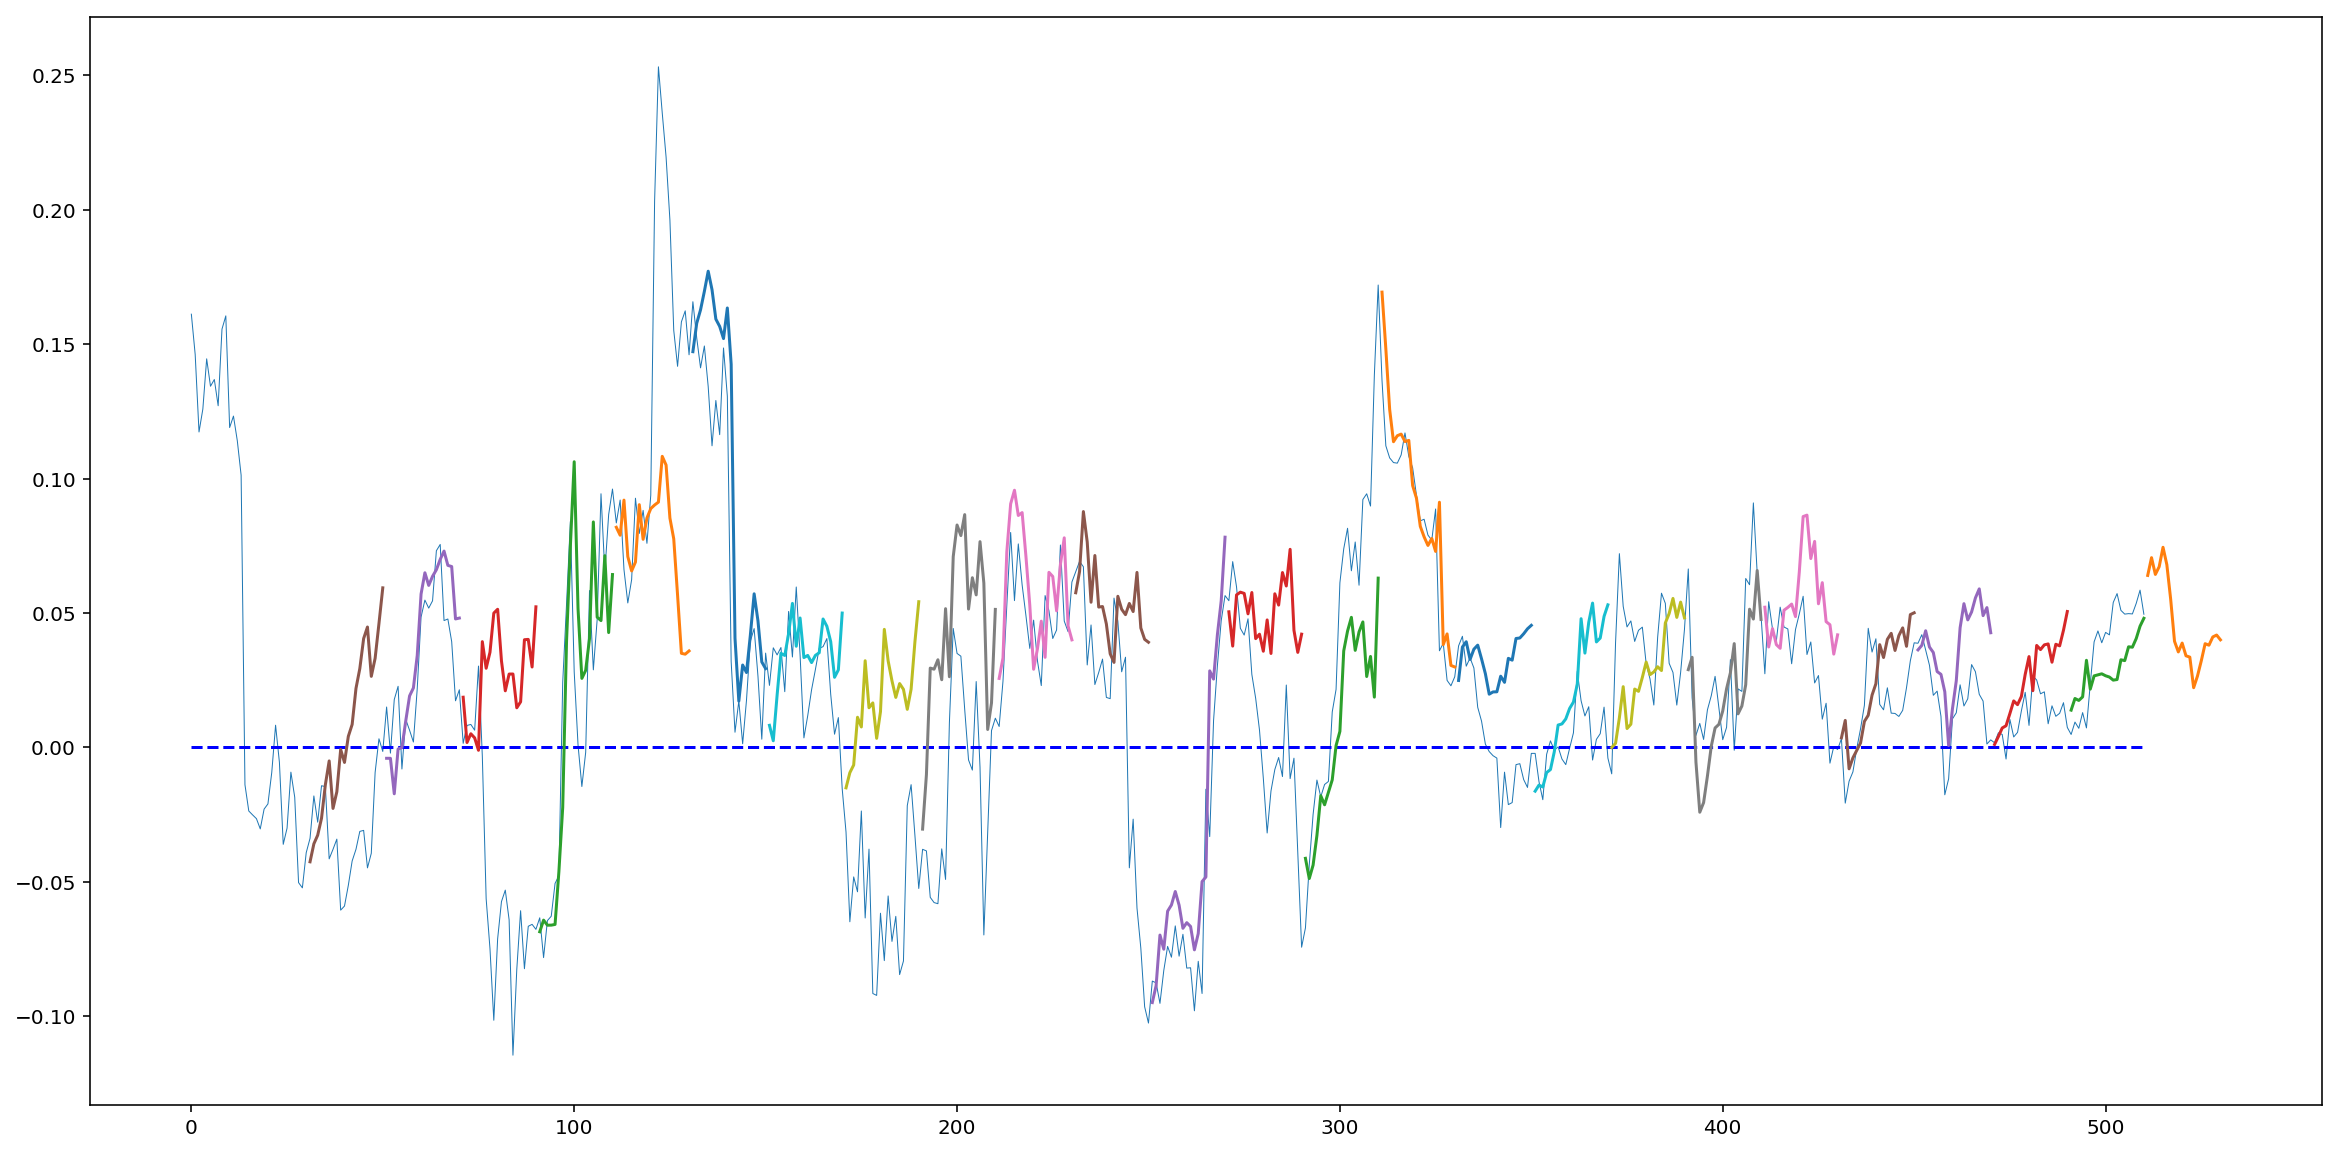

In [18]:
figure = plt.figure(facecolor='white', figsize=(20,10))
ax = figure.add_subplot(111)
ax.plot(y_val, linewidth=0.5)
ax.plot(np.zeros(len(y_val)), 'b--')

for i, pred in enumerate(prediction_seqs):
    padding = [None for p in range(len(y_val) - i * num_steps)]
    plot_data = padding + pred
    plt.plot(plot_data)

#### Plot prices

In [23]:
prices = convert_to_window_data(data, 20, norm=False)

In [24]:
train_price, val_price = split_data(prices)

In [25]:
last_prices = list(val_price[0])

In [26]:
for single in val_price[1:]:
    last_prices.append(single[-1])

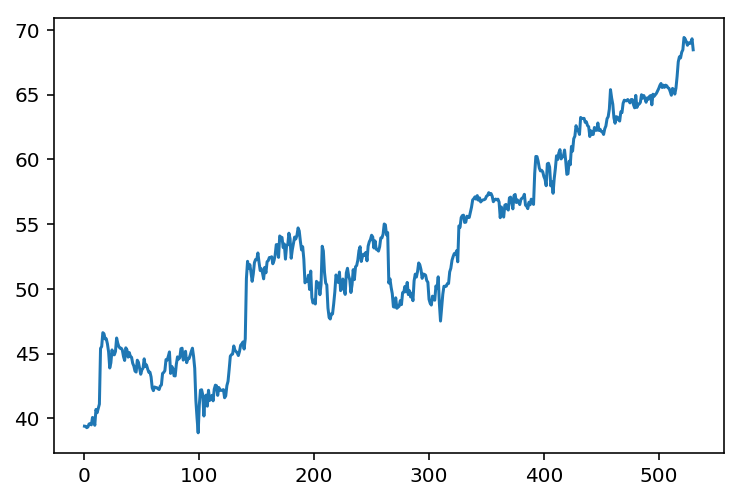

In [27]:
plt.plot(last_prices)

In [36]:
new_last_prices = [last_prices[i*num_steps:(i+1)*num_steps] for i in range(len(prediction_seqs))]

In [37]:
# pred_prices = []
# for i in range(len(val_price) // num_steps):
#     x = val_price[(len(val_price)-1) - i * num_steps][:num_steps]
#     single_pred = []
#     for j in range(num_steps):
#         single_pred.append(x[j] * (1+prediction_seqs[i][j]))
#     pred_prices.append(single_pred)

In [39]:
pred_prices = []
for i in range(len(new_last_prices)):
    #x = val_price[(len(val_price)-1) - i * num_steps][:num_steps]
    x = new_last_prices[i]
    single_pred = []
    #print(x)
    for j in range(num_steps):
        single_pred.append(x[j] * (1+prediction_seqs[i][j]))
    pred_prices.append(single_pred)    

In [40]:
flat_prices = [i for sublist in new_last_prices for i in sublist]

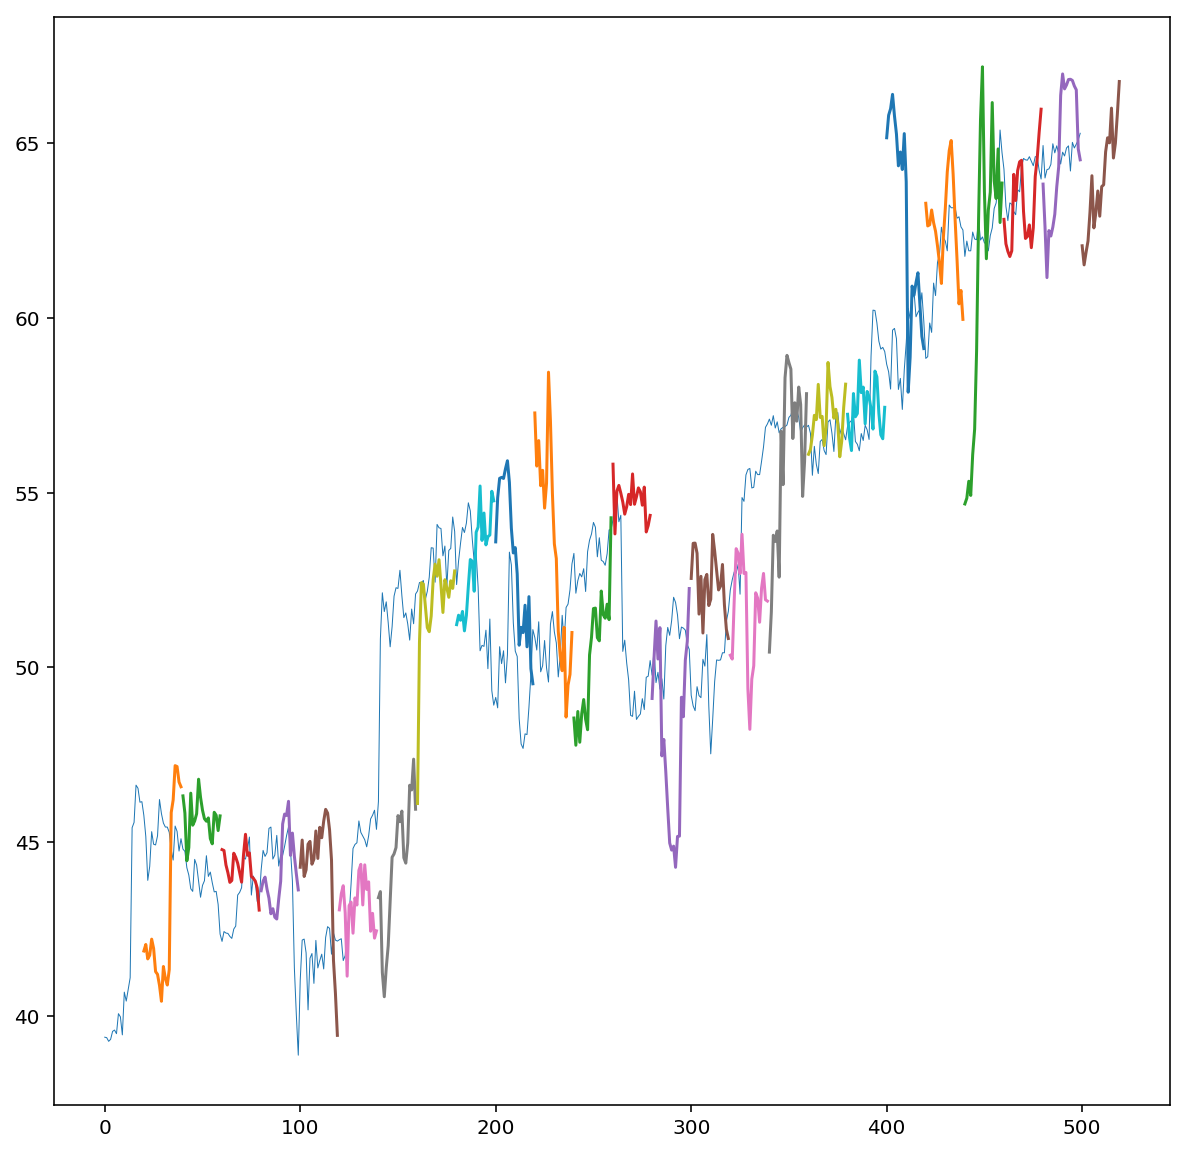

In [42]:
fig = plt.figure(facecolor='white', figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(flat_prices, linewidth=0.5)

for i, pred in enumerate(pred_prices):
    padding = [None for p in range((i+1)*num_steps)]
    plot_data = padding + pred
    plt.plot(plot_data)